# ML for Heterogeneous Treatment Effects

In empirical economics, researchers are often interested in how single factors and variables influence outcome variables of interest. The research questions are usually in the form of: *How does y change (on average) as a result of a change in x?* More formally, this is called the average causal effect of a change in x on y. Several econometric techniques and methods were and are being developed to isolate this effect in a variety of settings and obtain consistent and unbiased estimates. In contrast to that, Machine Learning (ML) focuses primarily on prediction problems. In most cases, it does not matter which of the predictors actually drives the outcome as long as the model results in an accurate prediction. 

Although both fields have different main tasks and strengths, there is econometric work which combines techniques from both topics. In this blog post, I will introduce one of such methods developed by [Chernozhukov and coauthors](https://arxiv.org/abs/1712.04802). I start with an introduction of the framework used in the paper and provide a short overview and explanation.

## Notation and Framework

The authors provide an empirical approach to assess heterogeneous treatment effects (HTE) in Randomized Controlled Trials (RCTs). In these experiments, the participants, often not even aware that they are taking part in a study, are randomly divided into a control and a treatment group. This ensures that the difference between the measured outcome variable in both groups can be attributed to the difference in treatment status, i.e. to the intervention itself. HTE describe how the effect of the studied intervention, also called treatment, varies among participants, i.e. if there exist heterogeneity, the treatment effect is not the same for all observations. In contrast to that, if there is no heterogeneity, the treatment effect is simply a constant. The method aims at making statements on HTE by estimating key features of the so-called conditional average treatment effect (CATE) function. This function describes the average treatment effects as a function of observed characteristics, also called covariates.

To more rigorously define causal effects introduced above, I will use [Rubin's causal model of potential outcomes](https://content.apa.org/record/1975-06502-001). Let ${D\in\{0,1\}}$ be a binary variable indicating treatment status and $Z$ be a vector of observed covariates. $Y(1)$ and $Y(0)$ denote potential outcomes under treatment and under no treatment. The baseline conditional average (BCA) function and the conditional average treatment effect function are defined as:
\begin{align}
    b_0(Z) &:= \textbf{E} \big[Y(0) \mid Z \big] \label{bca} \\ 
    s_0(Z) &:= \textbf{E} \big[Y(1)\mid Z \big]-\textbf{E} \big[Y(0) \mid Z \big].
\end{align}  
Using these definitions the outcome function can be written as
\begin{equation}
    Y = b_0(Z) + s_0(Z)D + U.
\end{equation}

The main idea from the paper is that a proxy $S(Z)$ of the true CATE function $s_0(Z)$ can be used to make inferential statements about the actual function which are statistically valid and justified. In order to create this proxy, any Machine Learning algorithm can be used. To do so, one predictive model is trained in the control group and a second predictive model is trained in the treatment group. In a second step, these models are used to predict the (hypothetical) outcomes under treatment and no treatment for the pooled sample of treated and control observations.

Using this proxy, the authors consider three key features of the true CATE function: 
1. The Best Linear Predictor (BLP) of $s_0(Z)$ using $S(Z)$
2. Group Average Treatment Effects (GATES) based on the proxy
3. Average characteristics of the most and least affected groups, called Classification Analysis (CLAN)

In this post, I will cover the first two characteristics.

## Best Linear Predictor - BLP

The authors show that the parameters $\beta_1$ and $\beta_2$ solving the problem of the best linear approximation can be identified by the following weighted linear regression:

\begin{equation}
    Y=\alpha^{\prime} X_1 + \beta_1\big(D-p(Z)\big)+\beta_2\big(D-p(Z)\big)\big(S(Z)-\textbf{E} [S(Z)]\big)+\epsilon,
\end{equation}

with weights 

\begin{equation}
w(Z)= \frac{1}{p(Z)(1-p(Z))}
\end{equation}

$X_1$ contains a constant, the estimated BCA function and the CATE proxy. $p(Z)$ denotes the propensity score, i.e. the probability of being treatment. For example, in a RCT in which half of the participants are randomly chosen to be treated, the propensity score for each observation is 0.5.

The parameter $\beta_1$ from this weighted regression is equal to $\textbf{E}[s_0(Z)]$, hence it corresponds to the average treatment effect for all observations. $\beta_2$, on the other hand, corresponds to the coefficient of a simple linear regression of $s_0(Z)$ on $S(Z)$ and can be utilized to evaluate how well $S(Z)$ approximates $s_0(Z)$ as well as to gain insights about treatment effect heterogeneity. If $\beta_2 = 0$, the CATE proxy and the true function are completely uncorrelated. Additionally, $\beta_2$ would also be zero if there was no heterogeneity, and thus $s_0(Z)$ was a constant. In contrast to this, $\beta_2 \ne 0$ implies that there is substantial heterogeneity and that it can be predicted by the proxy $S(Z)$. Therefore, testing for heterogeneous treatment effects corresponds to testing the hypothesis that $\beta_2 \ne 0$. 

## Sorted Group Average Treatment Effects - GATES

In addition to the BLP of the CATE function, the authors provide a strategy to identify groups of observations, which are more or less affected by the treatment, and to estimate ATEs in those groups. To do this, the observations are first sorted according to the predicted ML proxy $S(Z)$ and then divided into $k$ non-overlapping groups $G_1, G_2, ..., G_K$ of arbitrary sizes. They might for example be chosen by quantiles of the proxy predictor. The parameters of interest are the average treatment effects in these groups, called sorted group average treatment effects (GATES) which are denoted by 
\begin{align}
\gamma_k = \textbf{E}\big[s_0(Z) \mid G_k\big] \text{ for } k=1, ..., K.
\end{align}

These parameters can again be identified by a weighted linear regression using the same weights as in the estimation of the BLP coefficients. Specifically, the regression has the following form:
\begin{equation}
\label{gatesreg}
    Y=\alpha^{\prime} X_1 + \sum_{k=1}^K \gamma_k\big(D-p(Z)\big)\textbf{1}(G_k) + \nu.
\end{equation}

Chernozhukov and coauthors show that the coefficients $\gamma_k$ from this regression can be interpreted as the average treatment effects in the respective $k$th group.

## Sample Splitting and Estimation Uncertainty

To avoid overfitting the data, the data is split into two roughly equally sized samples: an auxiliary and a main sample. The auxiliary dataset is used to construct and train the ML models, and the main sample is used to actually construct the proxy and estimate the parameters of interest. In order to prevent accidentally splitting the sample into subsamples that largely deviate from the whole sample, the authors suggest 1) to run the estimation for many different splits (their recommendation is 100 splits) and to report medians of the estimates; and 2) to account for the additional uncertainty from sample splitting by reporting adjusted confidence intervals and p-values. For details, refer to the paper or to the detailed explanation in [my master thesis](https://github.com/tlary/genericmlinference).

In addition to that, the authors also provide a way to examine how well the respective algorithm approximates the true CATE function. They provide multiple ways to calculate these information criteria from both the BLP as well as the GATES estimation.

## Implementation and Example

The below stated implementation algorithm summarizes the steps needed to apply the above introduced estimation approach: 

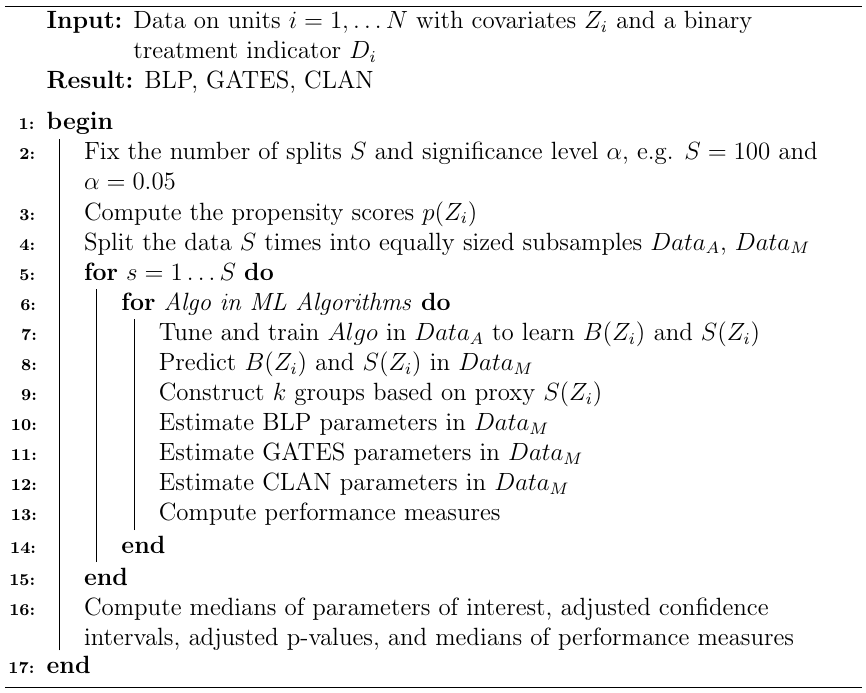

I recently implemented this estimation approach in my master thesis with a few additional tweaks and changes. However, in [this Github Repo](https://github.com/tlary/genericmlinference) I also provide code recreating the methodology as stated in the above provided algorithm. The implementation builds on [Max Kuhn's caret package](http://topepo.github.io/caret/index.html) to facilitate the construction of the CATE proxy using multiple algorithms. Currently, the provided code implements the approach for Elastic Net, XGBoost, Random Forests, simple Neural Networks and Neural Networks with a preceding principal component analysis (PCA) step. Since the code is rather extensive, I will not describe the code in detail here, but rather describe its use and provide a short synthetic example.

The code base is split into three broad categories: the first category comprises helper functions used throughout the main functions and implement some custom statistics, as for example upper and lower medians as explained in the authors' paper. The second category contains the functionality which actually implements the estimation approach and the analyses. This function returns a large object containing all the results. The functions from the third category are then used to aggregate and extract the results. 

The main function used for the estimation is called `create_cddf_object()`:

In [ ]:
create_cddf_object <- function(datatable, treatVar, outcomeVar, groupVar=NULL, 
                               method, colsNotToUse=NULL, numSplits=100, 
                               preprocess = c("center", "scale"),
                               sigLevel=0.05, seed=123, numGroups=10, quantiles=NULL,
                               CLANvars=NULL, propensityScores, verbose=0)

The function takes the following inputs:
- *datatable*: input data as a data.table
- *treatVar*: string containing the name of the binary treatment indicator
- *outcomeVar*: string containing the name of the outcome variable
- *groupVar*: string containing the name of a grouping variable, e.g. postcode; needs to be a factor variable; if provided, stratified sample splitting is used
- *method*: string containing the name of the ML algorithm used to create the CATE proxy; currently implemented: "enet", "ranger", "xgbTree", "nnet", "pcaNnet"
- *colsNotToUse*: vector of column names that should not be used for the model training
- *numSplits*: number of data splits
- *preprocess*: preprocessing option as used in caret's `train()` function
- *sigLevel*: significance level
- *seed*: seed to create identical splits for different methods
- *numGroups*: number of non-overlapping groups for GATES estimation; if provided, observations are split into (roughly) equally sized groups
- *quantiles*: alternative to *numGroups*; instead of number of groups a list of quantiles can be provided for custom groups; only one out of *numGroups* and *quantiles* can be used
- *CLANvars*: vector containing names of variables that should be used for the classification analysis (see paper or master thesis for more details)
- *propensityScores*: numeric vector containing the propensity scores for the observations contained in *datatable*
- *verbose*: values > 0 can be used to provide more information about the estimation process

Calling this function returns an object containing multiple nested lists with the results. This object can then be passed to the class of `extract_` functions to extract the desired information. These functions contain:
- `extract_blp()`
- `extract_gates()`
- `extract_performance_metrics()`
- `extract_test_results()` [not covered here]

In the following I use a brief example to demonstrate the main functionality:

I use a synthetic dataset generated with the [python opossum package](https://humboldt-wi.github.io/blog/research/applied_predictive_modeling_19/data_generating_process_blogpost/), the code can be found in my GitHub repo as well. The data consists of 20,000 observations, half of which are considered treated. There are heterogeneous treatment effects, around 50% of the sample have positive treatment effects, the remaining 50% exhibit negative treatment effects.

In [47]:
source("cddf_implementation.R")

The average treatment effect is -0.060 and the GATES for 5 groups are as follows:

In [ ]:
q <- quantcut(treatment$TE, q=5)
treatment[, group := q]
treatment[, group := factor(group, labels = 1:5)]
setorder(treatment, group)
treatment[, mean(TE), by=group]

| | Group 1                 | Group 2   | Group 3 | Group 4 | Group 5 | 
|---|---------------------------------|-------------------|----|-----|-----|
Average Treatment Effect (ATE) | -0.986                        | -0.165             | -0.000 | 0.129 |  0.703 | 


We now start by creating the results object for the implemented methods. Since the treated observations are randomly chosen, the propensity scores are 0.5 for all units.

*Note: Depending on the size of the data, the estimation procedure may take some time. The runtime using elastic net and nnet/pcaNNet can be reduced by parallel tuning the models. To do so, simply register a parallel backend before running the code. The code would then look like the following:*

```R
cl <- makePSOCKcluster(detectCores()-1) # leave one core for OS
registerDoParallel(cl) # register parallel backend
cddfEnet <- create_cddf_object(dt, treatVar="treatment", outcomeVar="outcome",
                           method="enet", numSplits=100, numGroups=5, 
                           propensityScores=propScores)
stopCluster(cl) # stop the cluster
registerDoSEQ # register sequential backend again
```

*XGBoost and ranger run in parallel by default without explicitly registering a parallel backend.*

In [2]:
dt <- fread("syntheticData.csv")
propScores  <- rep(0.5, 20000)

In [ ]:
cddfEnet <- create_cddf_object(dt, treatVar="treatment", outcomeVar="outcome",
                           method="enet", numSplits=100, numGroups=5, 
                           propensityScores=propScores)

In [ ]:
cddfRF <- create_cddf_object(dt, treatVar="treatment", outcomeVar="outcome",
                           method="ranger", numSplits=100, numGroups=5, 
                           propensityScores=propScores)

In [ ]:
cddfXGB <- create_cddf_object(dt, treatVar="treatment", outcomeVar="outcome",
                           method="xgbTree", numSplits=100, numGroups=5, 
                           propensityScores=propScores)

In [ ]:
cddfPcaNNet <- create_cddf_object(dt, treatVar="treatment", outcomeVar="outcome",
                           method="pcaNNet", numSplits=100, numGroups=5, 
                           propensityScores=propScores)

In [41]:
cddfEnet <- readRDS("enet.rds")
cddfRF <- readRDS("rf.rds")
cddfXGB <- readRDS("xgb.rds")
cddfPcaNNet <- readRDS("pcannet.rds")

Before reviewing the results, we first take a look at the performance criteria using `extract_performance_metrics()` to see which algorithm provides the best approximation to the CATE function. The higher the criteria, the better the approximation.

In [6]:
perfEnet <- extract_performance_metrics(cddfEnet)
perfRF  <- extract_performance_metrics(cddfRF)
perfXGB  <- extract_performance_metrics(cddfXGB)
perfPcaNNet  <- extract_performance_metrics(cddfPcaNNet)

|                         | Elastic Net | Random Forest | XGBoost     | Neural Net with PCA |
|-------------------------|-------------|---------------|-------------|------------|
| BLP - Criterion         | 0.0012 | 0.0777   | 0.0744 | 0.4601 |
| GATES - Criterion | 0.0292  | 0.0971    | 0.0958  | 0.4845 |

As can be seen from the table, the neural network with preceding PCA approximates the CATE by far the best. Hence, in the following only the results from this algorithm are reported. The BLP results reveal an estimated ATE of ...., which is close to the true ATE of -0.060. Moreover, as expected, from $\beta_2$ it follows that there exists heterogeneity and that the pcaNNet model is a good predictor since it is close to one and highly significant. 

In [9]:
blpPcaNNet  <- extract_blp(cddfPcaNNet)
blpPcaNNet[[2]]

|                   | ATE ($\beta_1$)                 | HET ($\beta_2$)   |
|-------------------|---------------------------------|-------------------|
| Coefficients      | -0.107                         | 0.928             |
| Confidence bands  | (-0.148 ; -0.066)             | (0.871 ; 0.984) |
| Adjusted p-values | [0.000]                         | [0.000]           |


Looking at the GATES, we see that the estimated group average treatment effects are also close to the actual effects. ...

|                   | Group 1                 | Group 2   | Group 3 | Group 4 | Group 5 | 
|-------------------|---------------------------------|-------------------|----|-----|-----|
| Coefficients      | -1.068                         | -0.697             | -0.003 | 0.499 |  0.741 | 
| Confidence bands  | (-1.159 ; -0.976)             | (-0.788 ; -0.605) | (-0.096 ; 0.089) | (0.408 ; 0.590) | (0.650 ; 0.833) |
| Adjusted p-values | [0.000]                         | [0.000]           | [0.000]           | [0.000]           | [0.000]           |

To sum up the results, the `plot_gates()` function can be used to provide a visual overview of the estimated effects. It takes three arguments: an object returned by `extract_gates()`, an object returned by `extract_blp()`, and an optional plot title. 

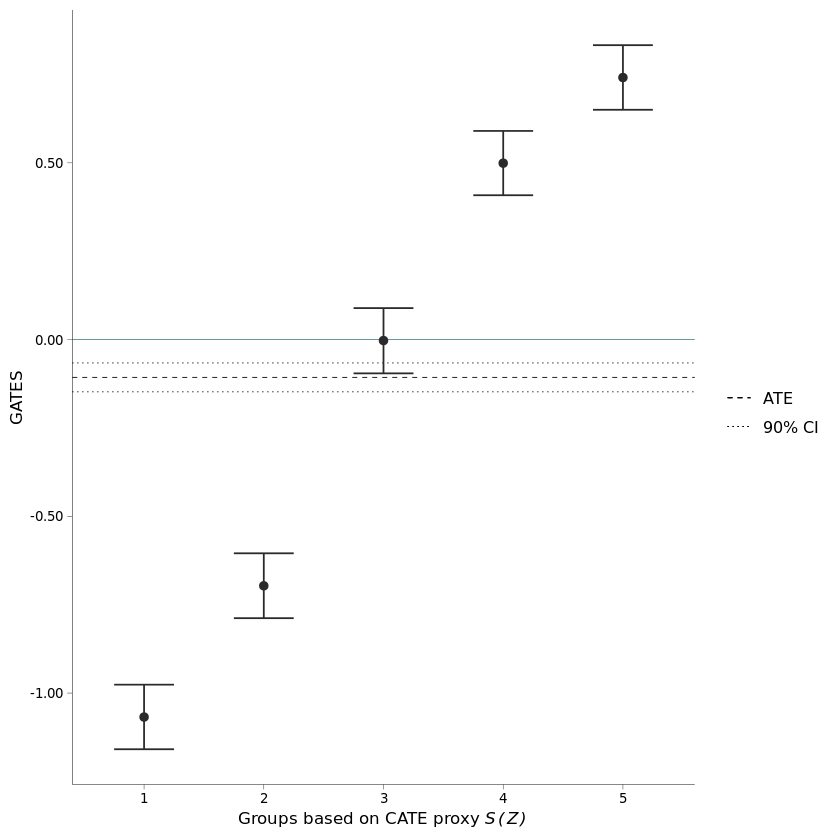

In [48]:
plot_gates(gatesPcaNNet, blpPcaNNet)